# <b>Assignment : DT</b>

In [93]:
import nltk
nltk.download("vader_lexicon")
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pickle
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from scipy.sparse import hstack

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud, STOPWORDS

import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<h1> Decision Tree </h1>

# <font color='red'> <b>Task - 1</b></font>

## 1.1 Loading Data

In [3]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/assignment files/Copy of preprocessed_data.csv')

##1.calculate sentiment scores for the essay feature

In [98]:
sid = SentimentIntensityAnalyzer()
sents = data['essay'].values
pol_score_vec = np.vectorize(sid.polarity_scores)
senti_scores = pol_score_vec(sents)

In [99]:
pos =[]
neg =[]
neu = []
comp = []
for sc in senti_scores:
    pos.append(sc['pos'])
    neg.append(sc['neg'])
    neu.append(sc['neu'])
    comp.append(sc['compound'])

data["neg"] = neg
data["pos"] = pos
data["neu"] = neu        
data["comp"] = comp

##2.split data

In [100]:
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

##3. tfidf vectorization of text data

In [101]:
tf_idf_vec = TfidfVectorizer(ngram_range=(1,4),max_features=5000)
x_train_essay_tfidf = tf_idf_vec.fit_transform(x_train['essay'].values)
x_test_essay_tfidf = tf_idf_vec.transform(x_test['essay'].values)

##4. tfidf w2v vectorization of text data

In [102]:
tf_idf = TfidfVectorizer()
tf_idf.fit(x_train['essay'])
tfidf_dict = dict(zip(tf_idf.get_feature_names_out(),list(tf_idf.idf_)))
tfidf_ftrs=set(tf_idf.get_feature_names_out())

In [103]:
with open('/content/drive/MyDrive/Colab Notebooks/assignment files/Copy of glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [104]:
def tfidf_w2v(x_train,model,glove_words,tf_idf_ftrs,tfidf_dict):
    tfidf_w2v =[]
    for essay in x_train:
        vec = np.zeros(300)
        tfidf_sum = 0
        for word in essay.split():
            if (word in glove_words) and (word in tf_idf_ftrs):
                vec += model[word]*tfidf_dict[word]
                tfidf_sum +=tfidf_dict[word]
        if tfidf_sum != 0:
            vec /=tfidf_sum
        tfidf_w2v.append(vec)
    return np.array(tfidf_w2v)

In [105]:
x_train_tfidf_w2v = tfidf_w2v(x_train['essay'],model,glove_words,tfidf_ftrs,tfidf_dict)
x_train_tfidf_w2v.shape

(73196, 300)

In [106]:
x_test_tfidf_w2v = tfidf_w2v(x_test['essay'],model,glove_words,tfidf_ftrs,tfidf_dict)
x_test_tfidf_w2v.shape

(36052, 300)

##5. Encoding categorical features

In [107]:
def cat_encoder(f_tr,f_te,y_tr,y_te):
    enc = CountVectorizer()
    x_tr_f_ohe = enc.fit_transform(f_tr.values)
    x_te_f_ohe = enc.transform(f_te.values)
    #f_features = enc.get_feature_names()

    print("After vectorizations")
    print(x_tr_f_ohe.shape, y_train.shape)
    print(x_te_f_ohe.shape, y_test.shape)
    print(enc.get_feature_names())
    print("="*100)

    return x_tr_f_ohe,x_te_f_ohe

###5.1 OneHotEncoding schoolstate

In [108]:
x_train_state_ohe, x_test_state_ohe = cat_encoder(x_train['school_state'],x_test['school_state'],y_train,y_test) 

After vectorizations
(73196, 51) (73196,)
(36052, 51) (36052,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


###5.2 OneHotEncoding  Teacher Prefix

In [109]:
x_train_teacher_prefix_ohe, x_test_teacher_prefix_ohe = cat_encoder(x_train['teacher_prefix'],x_test['teacher_prefix'],y_train,y_test)

After vectorizations
(73196, 5) (73196,)
(36052, 5) (36052,)
['dr', 'mr', 'mrs', 'ms', 'teacher']


###5.3 OHE Project_grade_category

In [110]:
x_train_pgc_ohe, x_test_pgc_ohe = cat_encoder(x_train['project_grade_category'],x_test['project_grade_category'],y_train,y_test)

After vectorizations
(73196, 4) (73196,)
(36052, 4) (36052,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


###5.4 OHE clean_categories

In [111]:
x_train_clean_cat_ohe, x_test_clean_cat_ohe = cat_encoder(x_train['clean_categories'],x_test['clean_categories'],y_train,y_test)

After vectorizations
(73196, 9) (73196,)
(36052, 9) (36052,)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']


###5.5 OHE clean_Subcategories

In [112]:
x_train_clean_subcat_ohe, x_test_clean_subcat_ohe = cat_encoder(x_train['clean_subcategories'],x_test['clean_subcategories'],y_train,y_test)

After vectorizations
(73196, 30) (73196,)
(36052, 30) (36052,)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']


##6. Encoding numerical features

In [113]:
def num_encoder(f_tr,f_te,y_tr,y_te):
    normalizer = Normalizer()
    normalizer.fit(f_tr.values.reshape(-1, 1))

    f_tr_norm = normalizer.transform(f_tr.values.reshape(-1,1))
    f_te_norm = normalizer.transform(f_te.values.reshape(-1,1))

    print("After vectorizations")
    print(f_tr_norm.shape, y_train.shape)
    print(f_te_norm.shape, y_test.shape)
    print("="*100)
    return f_tr_norm,f_te_norm

###1. Encoding price

In [114]:
x_train_price_norm,x_test_price_norm = num_encoder(x_train['price'],x_test['price'],y_train,y_test)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


###2. Encoding Teacher number of previously posted projects

In [115]:
x_train_tppp_norm,x_test_tppp_norm = num_encoder(x_train['teacher_number_of_previously_posted_projects'],x_test['teacher_number_of_previously_posted_projects'],y_train,y_test)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


###3. Encoding neg

In [116]:
x_train_neg_norm,x_test_neg_norm = num_encoder(x_train['neg'],x_test['neg'],y_train,y_test)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


###4. Encoding pos

In [117]:
x_train_pos_norm,x_test_pos_norm = num_encoder(x_train['pos'],x_test['pos'],y_train,y_test)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


###5. Encoding neu

In [118]:
x_train_neu_norm,x_test_neu_norm = num_encoder(x_train['neu'],x_test['neu'],y_train,y_test)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


###6. Encoding comp

In [119]:
x_train_comp_norm,x_test_comp_norm = num_encoder(x_train['comp'],x_test['comp'],y_train,y_test)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


##7. task1 set 1

###Stackup

In [120]:

x_tr_set1 = hstack((x_train_essay_tfidf,x_train_state_ohe,x_train_teacher_prefix_ohe,x_train_pgc_ohe,x_train_clean_cat_ohe,x_train_clean_subcat_ohe,x_train_price_norm,x_train_tppp_norm,x_train_neg_norm,x_train_pos_norm,x_train_neu_norm,x_train_comp_norm)).tocsr()
x_te_set1 = hstack((x_test_essay_tfidf, x_test_state_ohe, x_test_teacher_prefix_ohe, x_test_pgc_ohe,x_test_clean_cat_ohe,x_test_clean_subcat_ohe, x_test_price_norm,x_test_tppp_norm,x_test_neg_norm,x_test_pos_norm,x_test_neu_norm,x_test_comp_norm)).tocsr()

print("Final Data matrix")
print(x_tr_set1.shape, y_train.shape)
print(x_te_set1.shape, y_test.shape)
print("="*100)

Final Data matrix
(73196, 5105) (73196,)
(36052, 5105) (36052,)


###7.9 Perform hyperparameter tuning and plot heatmap or 3d plot

####Hyperparameter tuning with DT using GridSearchCV

In [121]:
params ={'max_depth':[1,5,10,50],'min_samples_split':[5,10,100,500]}

dt = DecisionTreeClassifier(class_weight='balanced')
grid_search = GridSearchCV(dt,params,cv=5,scoring='roc_auc',return_train_score = True,n_jobs = -1)
grid_search.fit(x_tr_set1,y_train)

train_auc = grid_search.cv_results_['mean_train_score']
train_auc_stdd = grid_search.cv_results_['std_train_score']
cv_auc = grid_search.cv_results_['mean_test_score']
cv_auc_std = grid_search.cv_results_['std_test_score']

print("Best score",grid_search.best_score_)
print('Best Hyper parameters',grid_search.best_params_)

Best score 0.6215255532487671
Best Hyper parameters {'max_depth': 10, 'min_samples_split': 500}


####Plotting heatmap

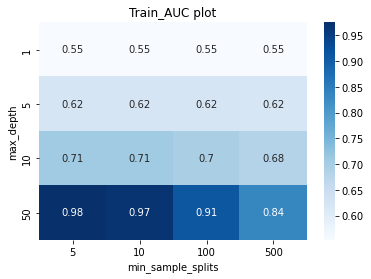

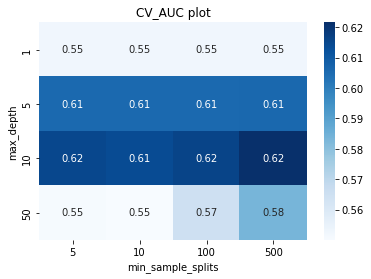

In [122]:
sns.heatmap(train_auc.reshape(4,4),annot = True,yticklabels =[1,5,10,50],xticklabels=[5,10,100,500],cmap="Blues")
plt.ylabel("max_depth")
plt.xlabel("min_sample_splits")
plt.title("Train_AUC plot")
plt.show()
print("\n")
sns.heatmap(cv_auc.reshape(4,4),annot = True,yticklabels =[1,5,10,50],xticklabels=[5,10,100,500],cmap="Blues")
plt.title("CV_AUC plot")
plt.ylabel("max_depth")
plt.xlabel("min_sample_splits")
plt.show()

###7.10 ROC curve of Train and Test data

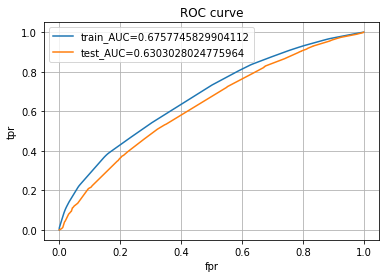

In [123]:
dt_set1 =dt.set_params(max_depth=grid_search.best_params_['max_depth'],min_samples_split=grid_search.best_params_['min_samples_split'])
dt_set1.fit(x_tr_set1,y_train)

y_train_pred = dt_set1.predict_proba(x_tr_set1)
y_test_pred = dt_set1.predict_proba(x_te_set1)

train_fpr,train_tpr, tr_thresholds = roc_curve(y_train,y_train_pred[:,1])
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred[:,1])

plt.plot(train_fpr, train_tpr,label="train_AUC="+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr, test_tpr, label="test_AUC="+str(auc(test_fpr,test_tpr)))

plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC curve")
plt.grid()
plt.show()

###7.11 Confusion matrix based on best threshold

In [124]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

the maximum value of tpr*(1-fpr) 0.37799539908562163 for threshold 0.493


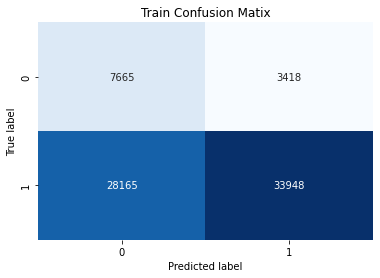


the maximum value of tpr*(1-fpr) 0.3475908854150091 for threshold 0.516


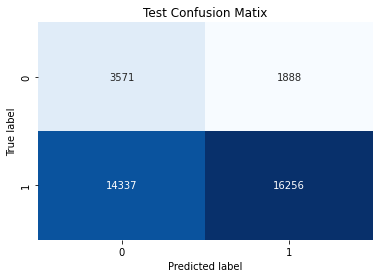

In [125]:
best_t_tr = find_best_threshold(tr_thresholds,train_fpr,train_tpr)
conf_mat_tr = confusion_matrix(y_train,predict_with_best_t(y_train_pred[:,1],best_t_tr))

sns.heatmap(conf_mat_tr,annot=True,fmt = 'd',cmap='Blues',cbar=False)
plt.title("Train Confusion Matix")
plt.ylabel("True label")
plt.xlabel("Predicted label")

plt.show()
print()
best_t_te = find_best_threshold(te_thresholds,test_fpr,test_tpr)
conf_mat_te = confusion_matrix(y_test,predict_with_best_t(y_test_pred[:,1],best_t_te))

sns.heatmap(conf_mat_te,annot=True,fmt = 'd',cmap='Blues',cbar=False)
plt.title("Test Confusion Matix")
plt.ylabel("True label")
plt.xlabel("Predicted label")

plt.show()

###7.12 All False_positive points

In [126]:
pred = predict_with_best_t(y_test_pred[:,1],best_t_te)

false_pos = []
for i in range(len(y_test)):
    if (y_test[i]==0) & (pred[i]==1):
        false_pos.append(i)

len(false_pos)

1888

####Making data frame of False positives

In [127]:
x_test_fp = pd.DataFrame(columns=x_test.columns)
x_test_fp = x_test.iloc[false_pos]
x_test_fp.shape

(1888, 12)

####Word cloud of essay text of false postives

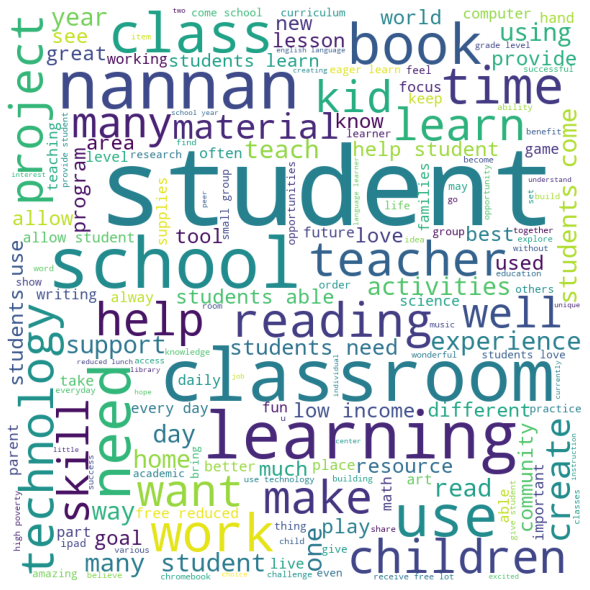

In [128]:
comment_words =' '
stopwords =set(STOPWORDS)
for es in x_test_fp['essay']:
    es = str(es)
    tokens = es.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    comment_words += " ".join(tokens)+" "
wordcloud = WordCloud(width=800,height= 800,background_color='white',
                      stopwords=stopwords,
                      min_font_size=10).generate(comment_words)
plt.figure(figsize=(8,8),facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

#####Obsrvations:
A Word Cloud or Tag Cloud is a visual representation of text data in the form of tags, which are typically single words whose importance is visualized by way of their size and color.


ref:https://www.dundas.com/resources/blogs/dundas-bi-features-functionality/visualizing-text-analysis-results-with-word-clouds
1. From above statement importance of the word is represnted by its size
2. In getting a False_positive outcome the most impotant features of essay are student, classroom,school,learning,nannan,use,technology etc.


####Box plot of price of Flase positive points

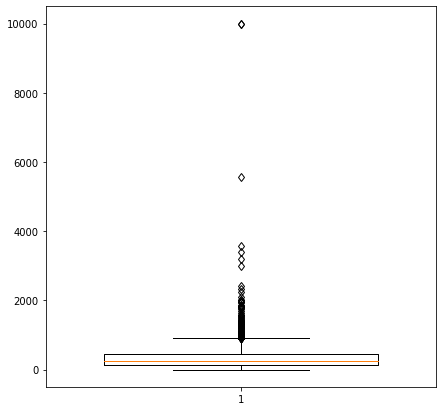

In [129]:
plt.figure(figsize=(7,7))
plt.boxplot(x_test_fp['price'],flierprops = {"marker":'d'},widths = 0.7)
plt.show()

####PDF of Teacher_previously_posted_projects_

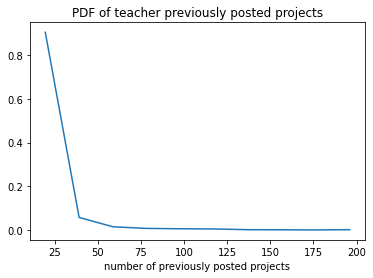

In [130]:
counts, bin_edges = np.histogram(x_test_fp['teacher_number_of_previously_posted_projects'],bins=10,density =True)

pdf = counts/sum(counts)
plt.plot(bin_edges[1:],pdf)
plt.title("PDF of teacher previously posted projects")
plt.xlabel("number of previously posted projects")
plt.show()

#####Observations:
1. The frequecny of teachers with number of previously posted projects < 50 is very high
2. This may mean teacher with less number of previously posted projectss will lead to false postives

##task1 set2

###stackup

In [131]:
x_tr_set2 = hstack((x_train_tfidf_w2v,x_train_state_ohe,x_train_teacher_prefix_ohe,x_train_pgc_ohe,x_train_clean_cat_ohe,x_train_clean_subcat_ohe,x_train_price_norm,x_train_tppp_norm,x_train_neg_norm,x_train_pos_norm,x_train_neu_norm,x_train_comp_norm)).tocsr()
x_te_set2 = hstack((x_test_tfidf_w2v, x_test_state_ohe, x_test_teacher_prefix_ohe, x_test_pgc_ohe,x_test_clean_cat_ohe,x_test_clean_subcat_ohe, x_test_price_norm,x_test_tppp_norm,x_test_neg_norm,x_test_pos_norm,x_test_neu_norm,x_test_comp_norm)).tocsr()

print("Final Data matrix")
print(x_tr_set2.shape, y_train.shape)
print(x_te_set2.shape, y_test.shape)
print("="*100)

Final Data matrix
(73196, 405) (73196,)
(36052, 405) (36052,)


###7.9 Perform hyperparameter tuning and plot heatmap or 3d plot

####Hyperparameter tuning with DT using GridSearchCV

In [133]:
params ={'max_depth':[1,5,10,50],'min_samples_split':[5,10,100,500]}

dt = DecisionTreeClassifier(class_weight='balanced')
grid_search = GridSearchCV(dt,params,cv=5,scoring='roc_auc',return_train_score = True,n_jobs =-1)
grid_search.fit(x_tr_set2,y_train)

train_auc = grid_search.cv_results_['mean_train_score']
train_auc_stdd = grid_search.cv_results_['std_train_score']
cv_auc = grid_search.cv_results_['mean_test_score']
cv_auc_std = grid_search.cv_results_['std_test_score']

print("Best score",grid_search.best_score_)
print('Best Hyper parameters',grid_search.best_params_)

Best score 0.608324025401785
Best Hyper parameters {'max_depth': 5, 'min_samples_split': 100}


####Plotting heatmap

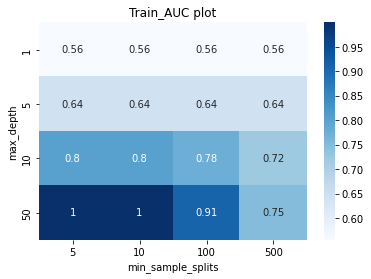

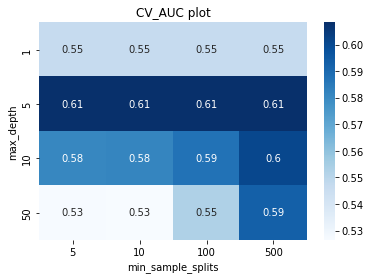

In [134]:
sns.heatmap(train_auc.reshape(4,4),annot = True,yticklabels =[1,5,10,50],xticklabels=[5,10,100,500],cmap="Blues")
plt.ylabel("max_depth")
plt.xlabel("min_sample_splits")
plt.title("Train_AUC plot")
plt.show()
print("\n")
sns.heatmap(cv_auc.reshape(4,4),annot = True,yticklabels =[1,5,10,50],xticklabels=[5,10,100,500],cmap="Blues")
plt.title("CV_AUC plot")
plt.ylabel("max_depth")
plt.xlabel("min_sample_splits")
plt.show()

###7.10 ROC curve of Train and Test data

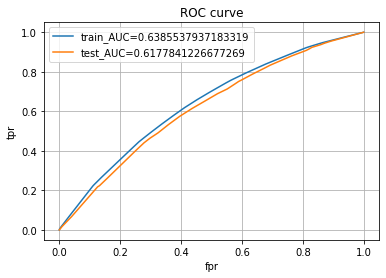

In [135]:
dt_set2 =dt.set_params(max_depth=grid_search.best_params_['max_depth'],min_samples_split=grid_search.best_params_['min_samples_split'])
dt_set2.fit(x_tr_set2,y_train)

y_train_pred = dt_set2.predict_proba(x_tr_set2)
y_test_pred = dt_set2.predict_proba(x_te_set2)

train_fpr,train_tpr, tr_thresholds = roc_curve(y_train,y_train_pred[:,1])
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred[:,1])

plt.plot(train_fpr, train_tpr,label="train_AUC="+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr, test_tpr, label="test_AUC="+str(auc(test_fpr,test_tpr)))

plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC curve")
plt.grid()
plt.show()

###7.11 Confusion matrix based on best threshold

the maximum value of tpr*(1-fpr) 0.36392898595131645 for threshold 0.521


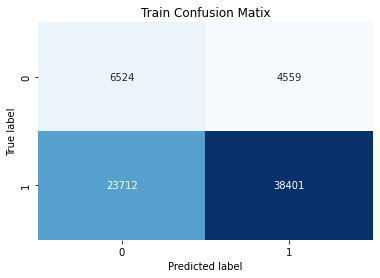


the maximum value of tpr*(1-fpr) 0.3473019756928185 for threshold 0.53


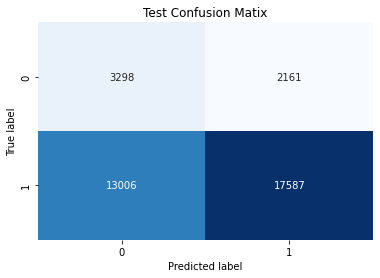

In [136]:
best_t_tr = find_best_threshold(tr_thresholds,train_fpr,train_tpr)
conf_mat_tr = confusion_matrix(y_train,predict_with_best_t(y_train_pred[:,1],best_t_tr))

sns.heatmap(conf_mat_tr,annot=True,fmt = 'd',cmap='Blues',cbar=False)
plt.title("Train Confusion Matix")
plt.ylabel("True label")
plt.xlabel("Predicted label")

plt.show()
print()
best_t_te = find_best_threshold(te_thresholds,test_fpr,test_tpr)
conf_mat_te = confusion_matrix(y_test,predict_with_best_t(y_test_pred[:,1],best_t_te))

sns.heatmap(conf_mat_te,annot=True,fmt = 'd',cmap='Blues',cbar=False)
plt.title("Test Confusion Matix")
plt.ylabel("True label")
plt.xlabel("Predicted label")

plt.show()

###7.12 All false_positive points 

In [137]:
pred = predict_with_best_t(y_test_pred[:,1],best_t_te)

false_pos = []
for i in range(len(y_test)):
    if (y_test[i]==0) & (pred[i]==1):
        false_pos.append(i)

len(false_pos)

2161

####Making data frame of False positives

In [138]:
x_test_fp = pd.DataFrame(columns=x_test.columns)
x_test_fp = x_test.iloc[false_pos]
x_test_fp.shape

(2161, 12)

####Word Cloud of essay text of False_positive points

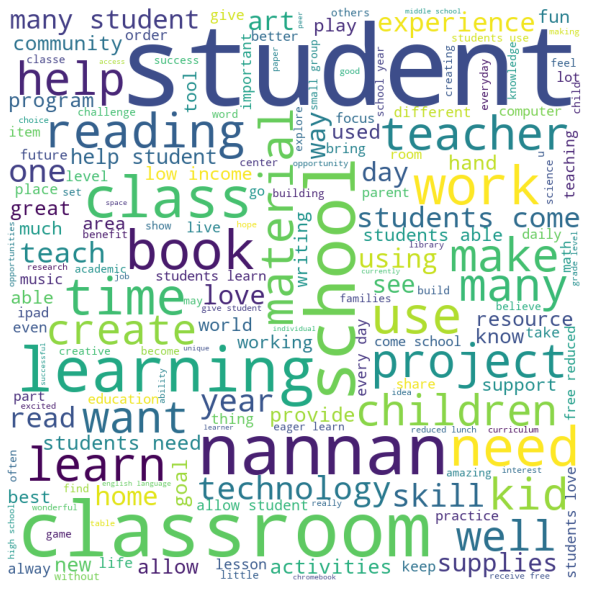

In [139]:
comment_words =' '
stopwords =set(STOPWORDS)
for es in x_test_fp['essay']:
    es = str(es)
    tokens = es.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    comment_words += " ".join(tokens)+" "
wordcloud = WordCloud(width=800,height= 800,background_color='white',
                      stopwords=stopwords,
                      min_font_size=10).generate(comment_words)
plt.figure(figsize=(8,8),facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

#####Observations:
1. The most important features of essay in getting false positives are student,school,nannan, learning,classroom,book,material,need
2. Almost similar to task1 wordcloud

####Box plot of price of False_positive points

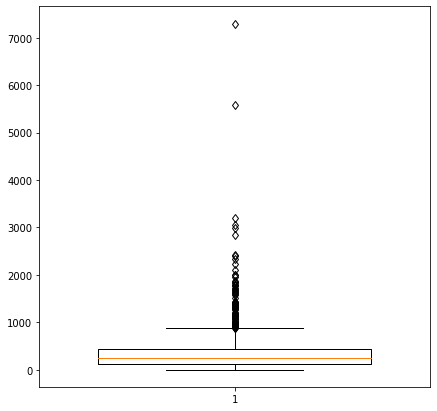

In [140]:
plt.figure(figsize=(7,7))
plt.boxplot(x_test_fp['price'],flierprops = {"marker":'d'},widths = 0.7)
plt.show()

####PDF of Teacher_previously_posted_projects

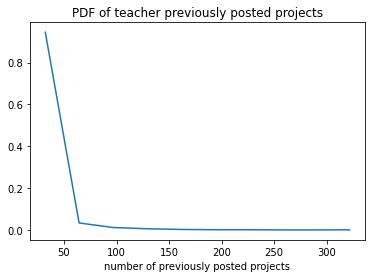

In [141]:
counts, bin_edges = np.histogram(x_test_fp['teacher_number_of_previously_posted_projects'],bins=10,density =True)

pdf = counts/sum(counts)
plt.plot(bin_edges[1:],pdf)
plt.title("PDF of teacher previously posted projects")
plt.xlabel("number of previously posted projects")
plt.show()

#####Observations:
1. similar to task1 the frquency of previously posted projects less than 50 is high

2. project with less number of previously posted projects may lead to false postive outcome

# <font color='red'> <b>Task - 2</b></font>

In [142]:
# 1. write your code in following steps for task 2
# 2. select all non zero features
# 3. Update your dataset i.e. X_train,X_test and X_cv so that it contains all rows and only non zero features
# 4. perform hyperparameter tuning and plot either heatmap or 3d plot.
# 5. Fit the best model. Plot ROC AUC curve and confusion matrix similar to model 1.


##Selecting non zero feature importance features

In [148]:
#Getting feature importance
dt_set1.set_params(max_depth=None,min_samples_split=500)
dt_set1.fit(x_tr_set1,y_train)

feat_imp = dt_set1.feature_importances_
#creating list of indexes of non zero feature importance
non_zero_feat =[]
for idx,f in enumerate(feat_imp):
    if f>0:
        non_zero_feat.append(idx)

#data of non zero feature imortance
x_tr_f = x_tr_set1[:,non_zero_feat]
x_te_f = x_te_set1[:,non_zero_feat]

print("shape of train and test data after selection")
print(x_tr_f.shape)
print(x_te_f.shape)



shape of train and test data after selection
(73196, 1081)
(36052, 1081)


##Hyper paramter tuning

In [149]:
params ={'max_depth':[1,5,10,50],'min_samples_split':[5,10,100,500]}

dt = DecisionTreeClassifier(class_weight='balanced')
grid_search = GridSearchCV(dt,params,cv=5,scoring='roc_auc',return_train_score = True,n_jobs =-1)
grid_search.fit(x_tr_f,y_train)

train_auc = grid_search.cv_results_['mean_train_score']
train_auc_stdd = grid_search.cv_results_['std_train_score']
cv_auc = grid_search.cv_results_['mean_test_score']
cv_auc_std = grid_search.cv_results_['std_test_score']

print("Best score",grid_search.best_score_)
print('Best Hyper parameters',grid_search.best_params_)



Best score 0.62642054810809
Best Hyper parameters {'max_depth': 10, 'min_samples_split': 500}


##Heatmap

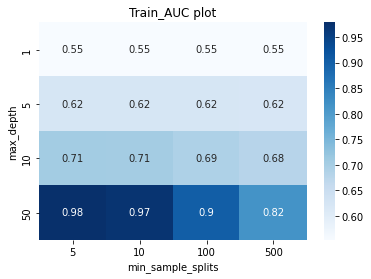

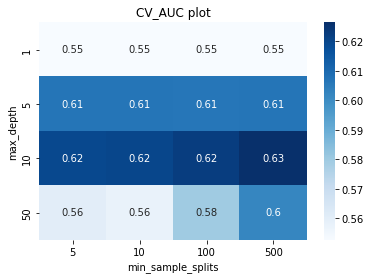

In [150]:
sns.heatmap(train_auc.reshape(4,4),annot = True,yticklabels =[1,5,10,50],xticklabels=[5,10,100,500],cmap="Blues")
plt.ylabel("max_depth")
plt.xlabel("min_sample_splits")
plt.title("Train_AUC plot")
plt.show()
print("\n")
sns.heatmap(cv_auc.reshape(4,4),annot = True,yticklabels =[1,5,10,50],xticklabels=[5,10,100,500],cmap="Blues")
plt.title("CV_AUC plot")
plt.ylabel("max_depth")
plt.xlabel("min_sample_splits")
plt.show()

##ROC curve

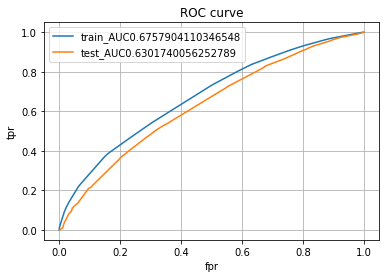

In [151]:
dt_best =dt.set_params(max_depth=grid_search.best_params_['max_depth'],min_samples_split=grid_search.best_params_['min_samples_split'])
dt_best.fit(x_tr_f,y_train)

y_train_pred = dt_best.predict_proba(x_tr_f)
y_test_pred = dt_best.predict_proba(x_te_f)


train_fpr,train_tpr, tr_thresholds = roc_curve(y_train,y_train_pred[:,1])
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred[:,1])

plt.plot(train_fpr, train_tpr,label="train_AUC"+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr, test_tpr, label="test_AUC"+str(auc(test_fpr,test_tpr)))

plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC curve")
plt.grid()
plt.show()

##Confusion matrix

the maximum value of tpr*(1-fpr) 0.3780065336266575 for threshold 0.493


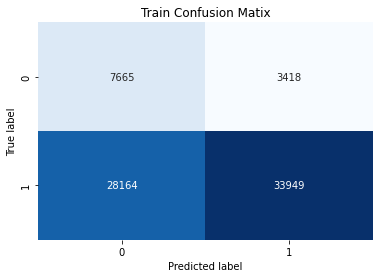


the maximum value of tpr*(1-fpr) 0.3475053561617082 for threshold 0.516


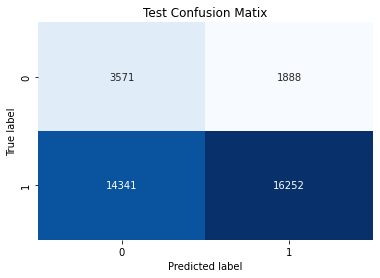

In [152]:
best_t_tr = find_best_threshold(tr_thresholds,train_fpr,train_tpr)
conf_mat_tr = confusion_matrix(y_train,predict_with_best_t(y_train_pred[:,1],best_t_tr))

sns.heatmap(conf_mat_tr,annot=True,fmt = 'd',cmap='Blues',cbar=False)
plt.title("Train Confusion Matix")
plt.ylabel("True label")
plt.xlabel("Predicted label")

plt.show()
print()
best_t_te = find_best_threshold(te_thresholds,test_fpr,test_tpr)
conf_mat_te = confusion_matrix(y_test,predict_with_best_t(y_test_pred[:,1],best_t_te))

sns.heatmap(conf_mat_te,annot=True,fmt = 'd',cmap='Blues',cbar=False)
plt.title("Test Confusion Matix")
plt.ylabel("True label")
plt.xlabel("Predicted label")

plt.show()

#Tabulated Results

In [156]:
from prettytable import PrettyTable, ALL

table = PrettyTable(hrules =ALL)
table.field_names= ["VECTORIZER","MODEL","MAX_DEPTH","MIN_SAMPLE_SPLITS",'AUC']
table.add_row(["TFIDF","DECISION TREE",10,500,0.63030])
table.add_row(["TFIDF W2V","DECISION TREE",5,100,0.61778])
table.add_row(["TFIDF NON ZERO FEATURE IMPORTANCE","DECISION TREE",10,500,0.63017])
print(table)

+-----------------------------------+---------------+-----------+-------------------+---------+
|             VECTORIZER            |     MODEL     | MAX_DEPTH | MIN_SAMPLE_SPLITS |   AUC   |
+-----------------------------------+---------------+-----------+-------------------+---------+
|               TFIDF               | DECISION TREE |     10    |        500        |  0.6303 |
+-----------------------------------+---------------+-----------+-------------------+---------+
|             TFIDF W2V             | DECISION TREE |     5     |        100        | 0.61778 |
+-----------------------------------+---------------+-----------+-------------------+---------+
| TFIDF NON ZERO FEATURE IMPORTANCE | DECISION TREE |     10    |        500        | 0.63017 |
+-----------------------------------+---------------+-----------+-------------------+---------+
